Fitted normal parameters: μ = 0.587, σ = 0.245


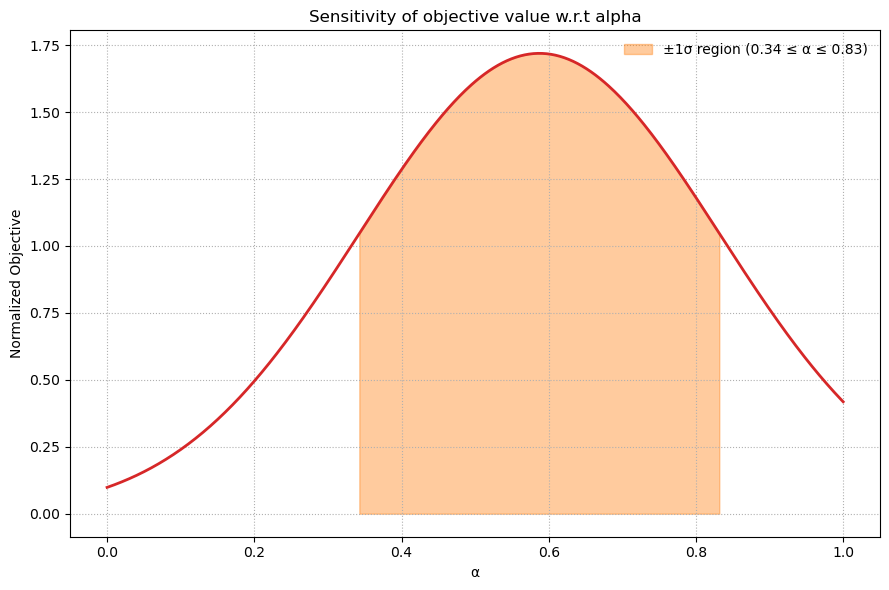

In [2]:
#normal curve for sensitivity of objective to alpha
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#load results dataset
df = pd.read_csv("optimal_results.csv")

#find best objective values for each alpha
best_per_alpha = (
    df.groupby("alpha", as_index=False)
      .agg({"objective": "min"})
      .sort_values("alpha")
)

alpha_vals = best_per_alpha["alpha"].to_numpy()
obj_vals   = best_per_alpha["objective"].to_numpy()

#Normalize
eps = 1e-9
max_obj = np.max(obj_vals)
weights = (max_obj - obj_vals) + eps  #higher weights mean better performance

mu = np.sum(alpha_vals * weights) / np.sum(weights)
var = np.sum(weights * (alpha_vals - mu)**2) / np.sum(weights)
sigma = np.sqrt(max(var, 1e-12))

print(f"Fitted normal parameters: μ = {mu:.3f}, σ = {sigma:.3f}")

#Normal curve generation
grid = np.linspace(0, 1, 500)
pdf = norm.pdf(grid, mu, sigma)

#Normalize to total area of 1
pdf /= np.trapz(pdf, grid)


plt.figure(figsize=(9,6))
plt.plot(grid, pdf, color='tab:red', lw=2)
region_low, region_high = mu - sigma, mu + sigma
mask = (grid >= region_low) & (grid <= region_high)
plt.fill_between(grid[mask], pdf[mask],
                 color='tab:orange', alpha=0.4,
                 label=f"±1σ region ({region_low:.2f} ≤ α ≤ {region_high:.2f})")

plt.xlabel("α")
plt.ylabel("Normalized Objective")
plt.title("Sensitivity of objective value w.r.t alpha")
plt.legend(frameon=False)
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


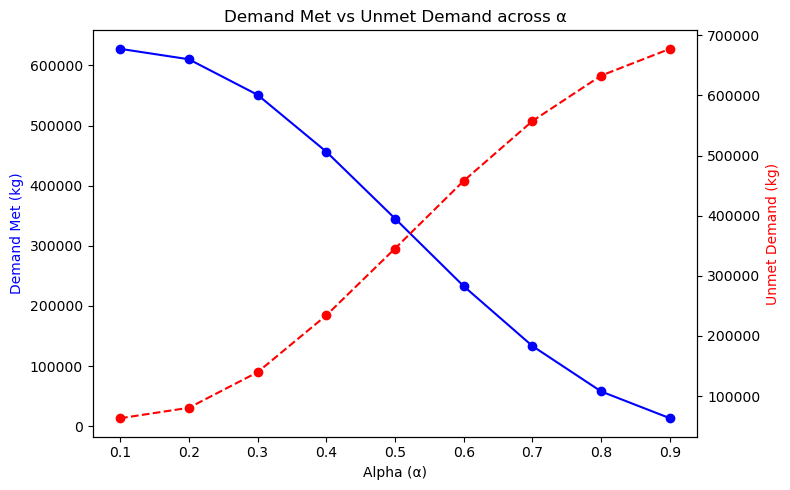

In [3]:
#comparison of met demand and unmet demand against alpha value
df = pd.read_csv("optimal_results.csv")
alpha_groups = df.groupby("alpha", as_index=False)[["sum_k_alloc_kg", "sum_Demand_kg"]].mean()
alpha_groups["unmet_kg"] = alpha_groups["sum_Demand_kg"] - alpha_groups["sum_k_alloc_kg"]

import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(8,5))
ax1.plot(alpha_groups["alpha"], alpha_groups["sum_k_alloc_kg"], 'b-o', label='Demand Met')
ax1.set_xlabel("Alpha (α)")
ax1.set_ylabel("Demand Met (kg)", color='b')

ax2 = ax1.twinx()
ax2.plot(alpha_groups["alpha"], alpha_groups["unmet_kg"], 'r--o', label='Unmet Demand')
ax2.set_ylabel("Unmet Demand (kg)", color='r')

plt.title("Demand Met vs Unmet Demand across α")
fig.tight_layout()
plt.show()

Plotting R values present: [0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 4.0, 6.0, 8.0]


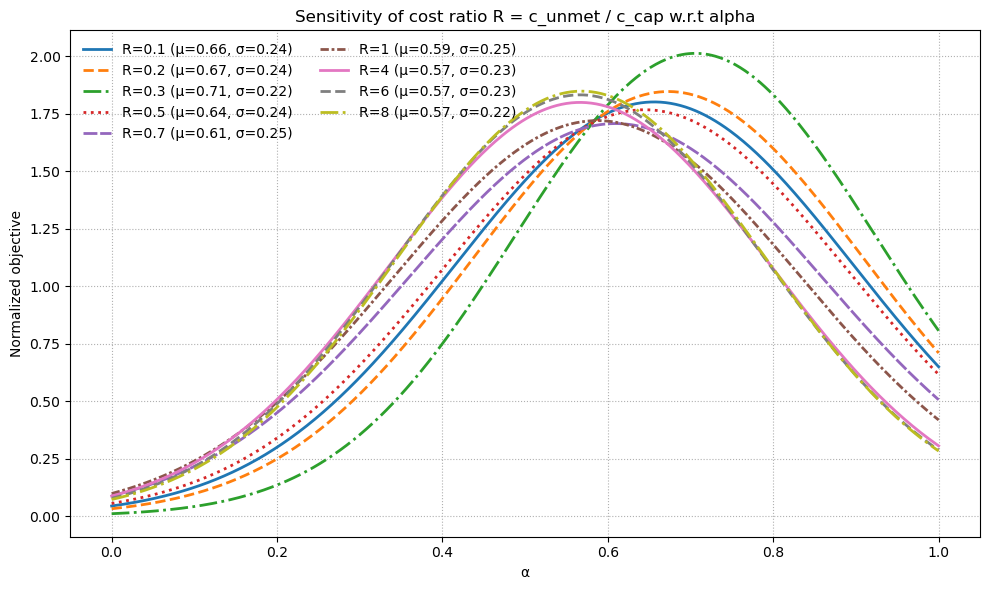

In [4]:
#sensitivity of cost ratio R = c_unmet / c_cap w.r.t alpha
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

#load dataset
df = pd.read_csv("optimal_results.csv")

need = {"alpha","c_capacity_per_kg","c_unmet_per_kg","objective"}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing columns in optimal_results.csv: {missing}")

df = df[(df["c_capacity_per_kg"] > 0) & (df["c_unmet_per_kg"] > 0)].copy()

#Cost ratio calculation
df["R"] = df["c_unmet_per_kg"] / df["c_capacity_per_kg"]

#Ratio values to be plotted
target_R_values = np.array([0.1, 0.2, 0.3, 0.5, 0.7, 1, 4, 6, 8])

logR = np.log(df["R"].values)
logT = np.log(target_R_values)
nearest_idx = np.abs(logR[:, None] - logT[None, :]).argmin(axis=1)
df["R_bucket"] = target_R_values[nearest_idx]

present_R = [r for r in target_R_values if r in df["R_bucket"].unique()]
print("Plotting R values present:", present_R)

def normal_curve_for_subset(sub_df):
    """For fixed R, find best-per-alpha objective, compute weights, fit normal curve."""
    grp = (sub_df.dropna(subset=["alpha","objective"])
                 .sort_values(["alpha","objective"])
                 .groupby("alpha", as_index=False)
                 .first()[["alpha","objective"]])
    if len(grp) < 3:
        return None

    alpha_vals = grp["alpha"].to_numpy()
    obj_vals   = grp["objective"].to_numpy()

    eps = 1e-9
    max_obj = obj_vals.max()
    w = (max_obj - obj_vals) + eps

    mu = np.sum(alpha_vals * w) / np.sum(w)
    var = np.sum(w * (alpha_vals - mu)**2) / np.sum(w)
    sigma = np.sqrt(max(var, 1e-12))

    grid = np.linspace(0, 1, 501)
    pdf = norm.pdf(grid, mu, sigma)
    area = np.trapz(pdf, grid)
    pdf /= area if area > 0 else 1
    return grid, pdf, mu, sigma

#Plotting
plt.figure(figsize=(10,6))
linestyles = ["-", "--", "-.", ":", (0, (5,1)), (0, (3,1,1,1))]

for i, r in enumerate(present_R):
    sub = df[df["R_bucket"] == r]
    out = normal_curve_for_subset(sub)
    if out is None:
        continue
    grid, pdf, mu, sigma = out
    ls = linestyles[i % len(linestyles)]
    label = f"R={r:g} (μ={mu:.2f}, σ={sigma:.2f})"
    plt.plot(grid, pdf, lw=2, linestyle=ls, label=label)

plt.xlabel("α")
plt.ylabel("Normalized objective")
plt.title("Sensitivity of cost ratio R = c_unmet / c_cap w.r.t alpha")
plt.grid(True, linestyle=":")
plt.legend(frameon=False, ncol=2)
plt.tight_layout()
plt.show()

